In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [1]:
from helpers import *
import yfinance as yf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

/Users/irfanjamil/anaconda3/lib/python3.10/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
spx = yf.Ticker('^SPX')
ndx = yf.Ticker('^NDX')

In [3]:
spx_calls = spx.option_chain('2024-03-06').calls
spx_puts = spx.option_chain('2024-03-06').puts

ndx_calls = ndx.option_chain('2024-03-06').calls
ndx_puts = ndx.option_chain('2024-03-06').puts


In [8]:
spx_calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPXW240306C04000000,2024-02-26 14:55:39+00:00,4000.0,1095.39,1087.0,1089.70,0.000000,0.000000,1.0,2604,2.286015,True,REGULAR,USD
1,SPXW240306C04250000,2024-03-04 18:38:30+00:00,4250.0,886.22,837.3,839.40,0.000000,0.000000,NaN,2,1.816651,True,REGULAR,USD
2,SPXW240306C04300000,2024-03-05 14:33:27+00:00,4300.0,806.78,786.9,789.00,20.440002,2.599385,1.0,2,1.717378,True,REGULAR,USD
3,SPXW240306C04350000,2024-02-07 20:59:22+00:00,4350.0,657.00,737.0,739.30,0.000000,0.000000,NaN,2,1.628298,True,REGULAR,USD
4,SPXW240306C04400000,2024-02-27 18:58:16+00:00,4400.0,671.43,687.3,689.50,0.000000,0.000000,1.0,1,1.539858,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,SPXW240306C05400000,2024-03-04 15:20:29+00:00,5400.0,0.05,0.0,0.00,0.000000,0.000000,200.0,570,0.125009,False,REGULAR,USD
130,SPXW240306C05450000,2024-03-04 20:48:29+00:00,5450.0,0.05,NaN,0.05,0.000000,0.000000,NaN,12,0.334968,False,REGULAR,USD
131,SPXW240306C05500000,2024-02-28 20:23:23+00:00,5500.0,0.07,0.0,0.05,0.000000,0.000000,10.0,23,0.372077,False,REGULAR,USD
132,SPXW240306C05600000,2024-02-29 19:39:42+00:00,5600.0,0.05,0.0,0.00,0.000000,0.000000,363.0,620,0.250007,False,REGULAR,USD


In [10]:
spx_calls.dtypes

contractSymbol                    object
lastTradeDate        datetime64[ns, UTC]
strike                           float64
lastPrice                        float64
bid                              float64
ask                              float64
change                           float64
percentChange                    float64
volume                           float64
openInterest                       int64
impliedVolatility                float64
inTheMoney                          bool
contractSize                      object
currency                          object
dtype: object

In [7]:
from datetime import datetime, timedelta, date

spx_calls['lastTradeDate'] = spx_calls.apply(lambda x: x['lastTradeDate'].to_pydatetime(), axis=1)
spx_puts['lastTradeDate'] = spx_puts.apply(lambda x: x['lastTradeDate'].to_pydatetime(), axis=1)
ndx_calls['lastTradeDate'] = ndx_calls.apply(lambda x: x['lastTradeDate'].to_pydatetime(), axis=1)
ndx_puts['lastTradeDate'] = ndx_puts.apply(lambda x: x['lastTradeDate'].to_pydatetime(), axis=1)

In [14]:
from datetime import timezone
spx_calls[spx_calls['lastTradeDate']>datetime(2024, 3, 5, tzinfo = timezone.utc)]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
2,SPXW240306C04300000,2024-03-05 14:33:27+00:00,4300.0,806.78,786.9,789.00,20.440002,2.599385,1.0,2,1.717378,True,REGULAR,USD
7,SPXW240306C04475000,2024-03-05 15:01:19+00:00,4475.0,627.05,612.1,614.30,13.179993,2.147033,2.0,0,1.398379,True,REGULAR,USD
18,SPXW240306C04690000,2024-03-05 15:45:38+00:00,4690.0,397.87,398.7,400.90,-48.570007,-10.879404,23.0,23,1.015966,True,REGULAR,USD
19,SPXW240306C04700000,2024-03-05 15:23:07+00:00,4700.0,394.94,387.2,389.30,-55.380005,-12.297922,1.0,17,0.978852,True,REGULAR,USD
30,SPXW240306C04800000,2024-03-05 14:52:30+00:00,4800.0,294.99,287.0,289.30,-44.790010,-13.182062,12.0,22,0.784502,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,SPXW240306C05265000,2024-03-05 14:52:10+00:00,5265.0,0.05,0.0,0.05,-0.100000,-66.666670,174.0,16,0.189461,False,REGULAR,USD
121,SPXW240306C05275000,2024-03-05 14:34:09+00:00,5275.0,0.07,0.0,0.05,-0.030000,-30.000002,103.0,873,0.198250,False,REGULAR,USD
122,SPXW240306C05285000,2024-03-05 15:46:43+00:00,5285.0,0.05,0.0,0.05,-0.050000,-50.000000,16.0,245,0.206063,False,REGULAR,USD
124,SPXW240306C05300000,2024-03-05 14:52:41+00:00,5300.0,0.05,0.0,0.05,0.000000,0.000000,15.0,191,0.218270,False,REGULAR,USD


In [15]:
spx_calls = spx_calls[spx_calls['lastTradeDate']>datetime(2024, 3, 5, tzinfo = timezone.utc)].sort_values(by=['strike']).reset_index(drop=True)

In [16]:
ndx_calls = ndx_calls[ndx_calls['lastTradeDate']>datetime(2024, 3, 5, tzinfo = timezone.utc)].sort_values(by=['strike']).reset_index(drop=True)
spx_puts = spx_puts[spx_puts['lastTradeDate']>datetime(2024, 3, 5, tzinfo = timezone.utc)].sort_values(by=['strike']).reset_index(drop=True)

ndx_puts = ndx_puts[ndx_puts['lastTradeDate']>datetime(2024, 3, 5, tzinfo = timezone.utc)].sort_values(by=['strike']).reset_index(drop=True)

In [18]:
spx_calls['midprice'] = spx_calls.apply(lambda x: (x['bid'] + x['ask'])/2, axis=1)
ndx_calls['midprice'] = ndx_calls.apply(lambda x: (x['bid'] + x['ask'])/2, axis=1)
spx_puts['midprice'] = spx_puts.apply(lambda x: (x['bid'] + x['ask'])/2, axis=1)
ndx_puts['midprice'] = ndx_puts.apply(lambda x: (x['bid'] + x['ask'])/2, axis=1)

In [19]:
ndx_calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,midprice
0,NDXP240306C16675000,2024-03-05 14:43:50+00:00,16675.0,1358.77,1228.20,1247.20,508.670040,59.836494,1.0,1,0.871957,True,REGULAR,USD,1237.700
1,NDXP240306C16780000,2024-03-05 14:43:50+00:00,16780.0,1253.93,1131.50,1149.20,-276.099980,-18.045395,1.0,20,0.840334,True,REGULAR,USD,1140.350
2,NDXP240306C17700000,2024-03-05 15:17:57+00:00,17700.0,280.80,235.50,243.80,-304.340030,-52.011486,2.0,3,0.331065,True,REGULAR,USD,239.650
3,NDXP240306C17800000,2024-03-05 15:45:57+00:00,17800.0,152.45,152.80,157.90,-347.669980,-69.517310,3.0,8,0.274891,True,REGULAR,USD,155.350
4,NDXP240306C17850000,2024-03-05 15:45:57+00:00,17850.0,120.25,121.60,125.10,-318.190000,-72.573210,3.0,18,0.259754,False,REGULAR,USD,123.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,NDXP240306C18650000,2024-03-05 14:43:14+00:00,18650.0,0.47,0.35,0.70,-13.009999,-96.513350,14.0,2,0.245857,False,REGULAR,USD,0.525
59,NDXP240306C18725000,2024-03-05 15:27:27+00:00,18725.0,0.45,0.30,0.55,-1.950000,-81.250000,21.0,6,0.258003,False,REGULAR,USD,0.425
60,NDXP240306C18750000,2024-03-05 14:51:21+00:00,18750.0,0.30,0.25,0.55,-1.700000,-85.000000,5.0,22,0.264168,False,REGULAR,USD,0.400
61,NDXP240306C18825000,2024-03-05 15:18:23+00:00,18825.0,0.20,0.25,0.50,-1.720000,-89.583330,2.0,5,0.279792,False,REGULAR,USD,0.375


In [21]:
ndx_calls = ndx_calls[['strike', 'bid', 'midprice', 'ask', 'impliedVolatility']]
spx_calls = spx_calls[['strike', 'bid', 'midprice', 'ask', 'impliedVolatility']]
ndx_puts = ndx_puts[['strike', 'bid', 'midprice', 'ask', 'impliedVolatility']]
spx_puts = spx_puts[['strike', 'bid', 'midprice', 'ask', 'impliedVolatility']]

In [22]:
spx_calls

,strike,bid,midprice,ask,impliedVolatility
0,4300.0,786.9,787.950,789.00,1.717378
1,4475.0,612.1,613.200,614.30,1.398379
2,4690.0,398.7,399.800,400.90,1.015966
3,4700.0,387.2,388.250,389.30,0.978852
4,4800.0,287.0,288.150,289.30,0.784502
...,...,...,...,...,...
70,5265.0,0.0,0.025,0.05,0.189461
71,5275.0,0.0,0.025,0.05,0.198250
72,5285.0,0.0,0.025,0.05,0.206063
73,5300.0,0.0,0.025,0.05,0.218270


In [24]:
'''
This cell of code is taken from David Duarte's answer on StackOverflow 
https://stackoverflow.com/questions/61289020/fast-implied-volatility-calculation-in-python
'''

from scipy.stats import norm
N = norm.cdf

def bs_call(S, K, T, r, vol):
    d1 = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    return S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)

def bs_vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def find_vol(target_value, S, K, T, r, *args):
    MAX_ITERATIONS = 10000
    PRECISION = 1.0e-5
    sigma = 0.5
    for i in range(0, MAX_ITERATIONS):
        price = bs_call(S, K, T, r, sigma)
        vega = bs_vega(S, K, T, r, sigma)
        diff = target_value - price  # our root
        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)
    return sigma # value wasn't found, return best guess so far

In [23]:
annualized_rate = .05374
r = np.log(1+annualized_rate)

In [30]:
r

0.05234574037193529

In [25]:
spx_calls['est_iv'] = spx_calls.apply(lambda x: find_vol(x['midprice'], 5078.65, x['strike'], 1/252, r) , axis=1)

/var/folders/8r/fr9y19j57554vvz5607f_l4h0000gn/T/ipykernel_11094/4260677647.py:28: RuntimeWarning: divide by zero encountered in double_scalars
  sigma = sigma + diff/vega # f(x) / f'(x)
/var/folders/8r/fr9y19j57554vvz5607f_l4h0000gn/T/ipykernel_11094/4260677647.py:10: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*np.sqrt(T))
/var/folders/8r/fr9y19j57554vvz5607f_l4h0000gn/T/ipykernel_11094/4260677647.py:15: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
/var/folders/8r/fr9y19j57554vvz5607f_l4h0000gn/T/ipykernel_11094/906340853.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spx_calls['est_iv'] 

In [26]:
spx_calls

,strike,bid,midprice,ask,impliedVolatility,est_iv
0,4300.0,786.9,787.950,789.00,1.717378,NaN
1,4475.0,612.1,613.200,614.30,1.398379,NaN
2,4690.0,398.7,399.800,400.90,1.015966,0.904574
3,4700.0,387.2,388.250,389.30,0.978852,0.851422
4,4800.0,287.0,288.150,289.30,0.784502,0.666667
...,...,...,...,...,...,...
70,5265.0,0.0,0.025,0.05,0.189461,0.190534
71,5275.0,0.0,0.025,0.05,0.198250,0.199714
72,5285.0,0.0,0.025,0.05,0.206063,0.208842
73,5300.0,0.0,0.025,0.05,0.218270,0.222444


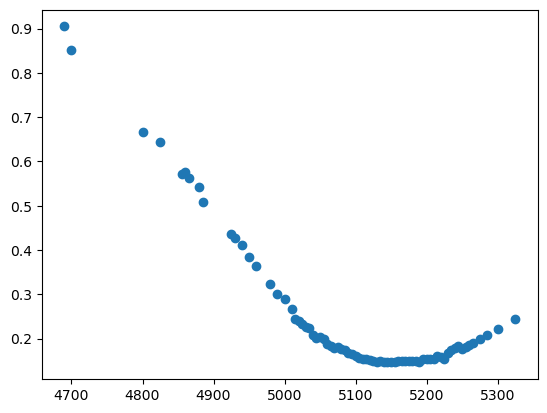

In [27]:
plt.scatter(spx_calls['strike'], spx_calls['est_iv'])

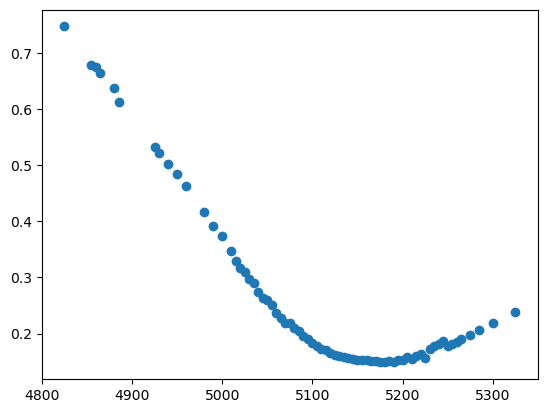

In [34]:
plt.scatter(spx_calls[spx_calls['strike']>4800]['strike'], spx_calls[spx_calls['strike']>4800]['impliedVolatility'])

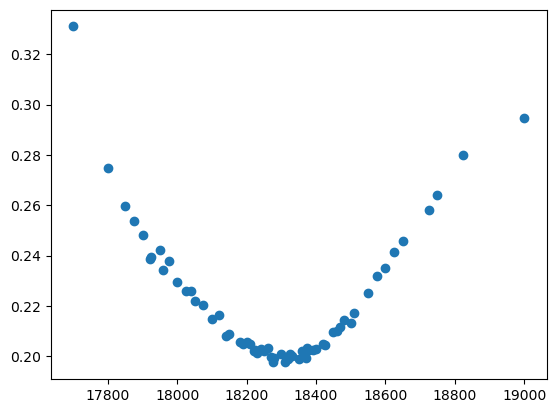

In [33]:
plt.scatter(ndx_calls[ndx_calls['strike'] > 17500]['strike'], ndx_calls[ndx_calls['strike'] > 17500]['impliedVolatility'])

In [29]:
spx_calls.describe()

,strike,bid,midprice,ask,impliedVolatility,est_iv
count,75.000000,75.000000,75.000000,75.000000,75.000000,73.000000
mean,5068.600000,75.837333,76.240333,76.643333,0.329004,0.255874
std,180.203639,139.528400,139.871220,140.214832,0.288515,0.169133
min,4300.000000,0.000000,0.025000,0.050000,0.148446,0.146089
25%,5005.000000,0.150000,0.175000,0.200000,0.160859,0.153897
50%,5100.000000,11.900000,11.950000,12.000000,0.204674,0.181639
75%,5192.500000,83.600000,84.450000,85.300000,0.359778,0.244909
max,5325.000000,786.900000,787.950000,789.000000,1.717378,0.904574


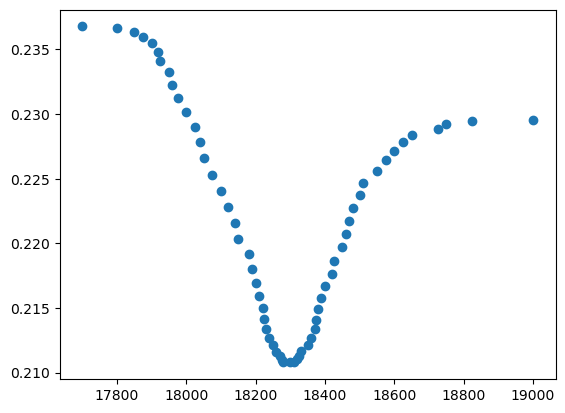

In [77]:
from scipy.ndimage import gaussian_filter1d
#ndx value 17897.87

#plt.scatter(ndx_calls[ndx_calls['strike'] > 17500]['strike'], ndx_calls[ndx_calls['strike'] > 17500]['impliedVolatility'])
y = gaussian_filter1d(ndx_calls[ndx_calls['strike'] > 17500]['impliedVolatility'], 14)
plt.scatter(ndx_calls[ndx_calls['strike'] > 17500]['strike'], y)
plt.show()

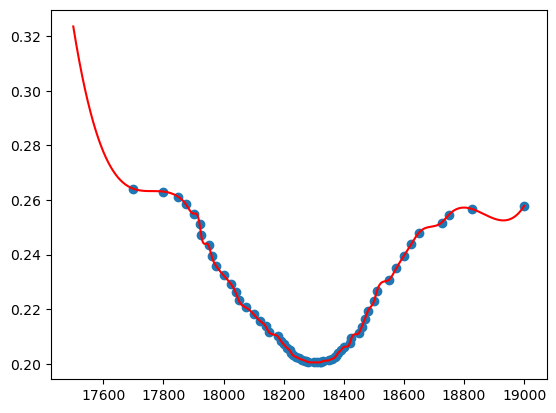

In [69]:
from scipy.interpolate import CubicSpline

cs = CubicSpline(ndx_calls[ndx_calls['strike'] > 17500]['strike'], y)
strike_ar = np.linspace(17500, 19000, 1501)

y_interp = cs(strike_ar)
plt.scatter(ndx_calls[ndx_calls['strike'] > 17500]['strike'], y)
plt.plot(strike_ar, y_interp, c='r')



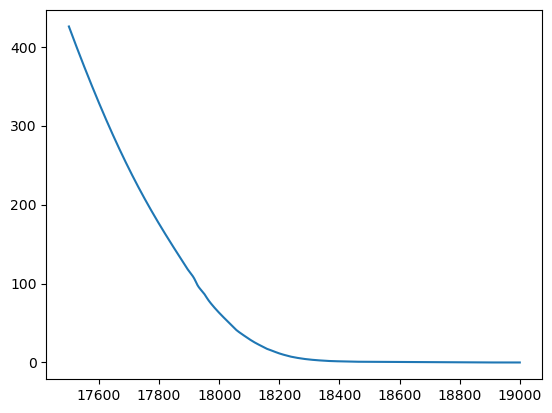

In [70]:
d = {'strike': [], 'price': []}
for x in np.linspace(17500, 19000, 30002):
    iv = cs(x)
    pr = bs_call(17897.87, x, 1/252, r, iv)
    d['strike'].append(x)
    d['price'].append(pr)
df = pd.DataFrame(data=d)
plt.plot(df['strike'], df['price'])

In [71]:
sp_ar = np.linspace(17500, 19000, 1000000)
prices = []
fd = []
sd = []

for x in sp_ar:
    iv = cs(x)
    pr = bs_call(17897.87, x, 1/252, r, iv)
    prices.append(pr)


In [72]:
for i in range(sp_ar.shape[0]):
    if i == 0:
        delta = sp_ar[1] - sp_ar[0]
        rise = prices[1] - prices[0]
        fd.append(rise/delta)
    elif i == sp_ar.shape[0] - 1:
        delta = sp_ar[i] - sp_ar[i-1]
        rise = prices[i] - prices[i-1]
        fd.append(rise/delta)
    else:
        delta = sp_ar[i+1] - sp_ar[i-1]
        rise = prices[i+1] - prices[i-1]
        fd.append(rise/delta)

for i in range(sp_ar.shape[0]):
    if i == 0:
        delta = sp_ar[1] - sp_ar[0]
        rise = fd[1] - fd[0]
        sd.append(rise/delta)
    elif i == sp_ar.shape[0] - 1:
        delta = sp_ar[i] - sp_ar[i-1]
        rise = fd[i] - fd[i-1]
        sd.append(rise/delta)
    else:
        delta = sp_ar[i+1] - sp_ar[i-1]
        rise = fd[i+1] - fd[i-1]
        sd.append(rise/delta)

pdf = sd

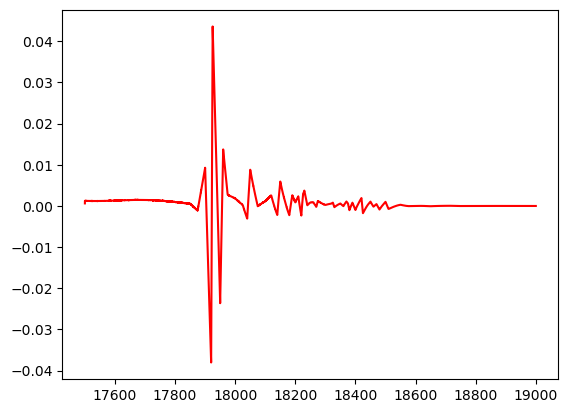

In [73]:
plt.plot(sp_ar, pdf, c='r')

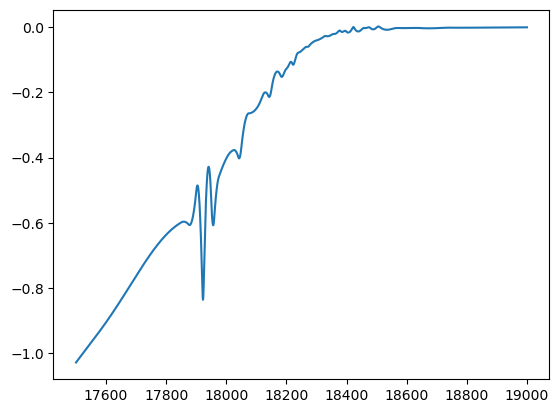

In [74]:
plt.plot(sp_ar, fd)

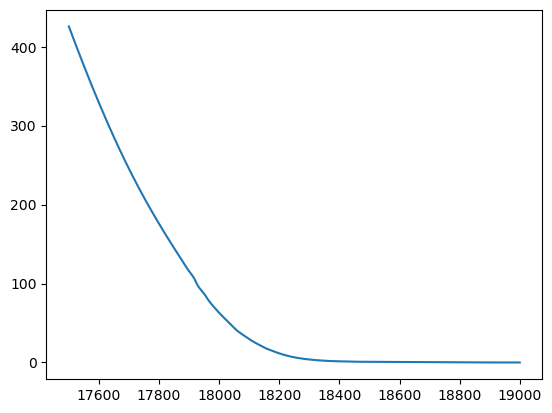

In [78]:
plt.plot(sp_ar, prices)

In [79]:
np.polyfit(np.log(sp_ar), prices, 1)

array([-4161.44422121, 40909.2353893 ])

In [81]:
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a*np.exp(-b*x) + c

popt, pcov = curve_fit(func, sp_ar, prices)

/Users/irfanjamil/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [82]:
popt

array([ 1.        ,  1.        , 78.64806564])

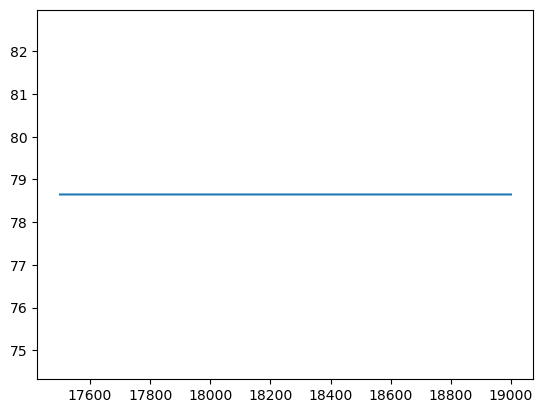